In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
import cv2

In [3]:
metadata_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
metadata.shape

(10015, 7)

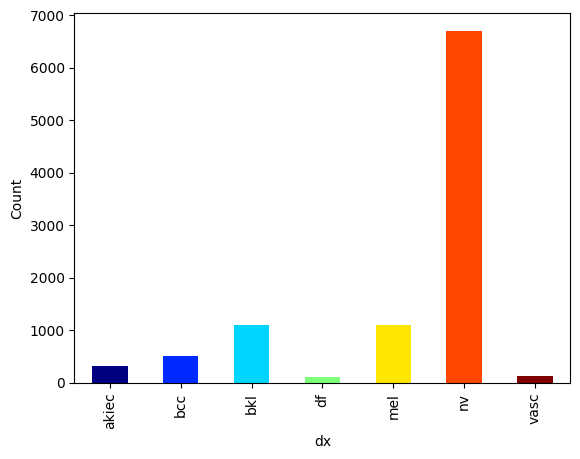

In [5]:
count = metadata.dx.value_counts().sort_index()

unique_vals = count.index
colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

count.plot(kind='bar', color=colors)

plt.ylabel('Count')
plt.show()

In [6]:
def check_for_missing_data(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    return summary

check_for_missing_data(metadata)

Name   dtypes  Missing
0     lesion_id   object        0
1      image_id   object        0
2            dx   object        0
3       dx_type   object        0
4           age  float64       57
5           sex   object        0
6  localization   object        0

In [7]:
metadata.fillna({'age': metadata['age'].mean()}, inplace=True)

In [8]:
def convert_float_to_int(df, column_name):
    if df[column_name].dtype == 'float64':
        df[column_name] = df[column_name].astype(int)
    return df

metadata = convert_float_to_int(metadata,'age')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           10015 non-null  int64 
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
dtypes: int64(1), object(6)
memory usage: 547.8+ KB


In [9]:
def check_for_duplicate_rows(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum()
    return print("Number of Samples:" ,size[0],"\nDuplicated Entries: " ,sum_duplicates,"\nNull Entries:","\n",sum_null)

check_for_duplicate_rows(metadata)

Number of Samples: 10015 
Duplicated Entries:  0 
Null Entries: 
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [10]:
lesion_id_cnt = metadata['lesion_id'].value_counts()
def check_duplicates_lesions(id):
    if lesion_id_cnt[id] > 1:
        return True
    else:
        return False

metadata['dup_les'] = metadata['lesion_id'].map(check_duplicates_lesions)

metadata['dup_les'].value_counts()

dup_les
False    5514
True     4501
Name: count, dtype: int64

In [11]:
metadata = metadata[metadata.dup_les == False]
metadata.shape

(5514, 8)

### Load the image paths

Create 2 paths from input. The images are separated in these paths, so if they do not exist in path 1 they probably exist in path 2. Scanning all the rows using the "dx" and the "image_id" columns we can add the image path in a separete column in the dataframe.

In [12]:
base1_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
base2_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

image_paths = []

for index, row in metadata.iterrows():
    image_id = row['image_id']

    image_path_1 = os.path.join(base1_path, f'{image_id}.jpg')
    image_path_2 = os.path.join(base2_path, f'{image_id}.jpg')

    if os.path.exists(image_path_1):
        image_paths.append(image_path_1)
    elif os.path.exists(image_path_2):
        image_paths.append(image_path_2)
    else:
        print(f'Image {image_id} not found in either path.')

# Add the image paths to your DataFrame
metadata['image_path'] = image_paths

metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                           image_path  
10  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
15  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
20  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
33  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
34  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

In [13]:
metadata.shape

(5514, 9)

### Exploration

<Axes: ylabel='count'>

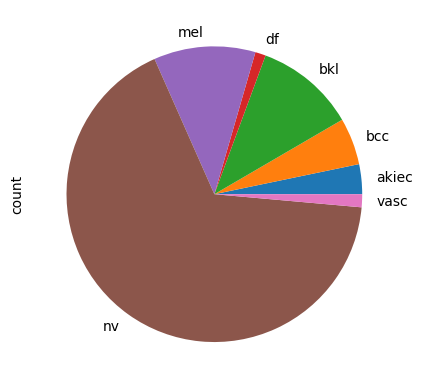

In [14]:
count.plot(kind='pie')

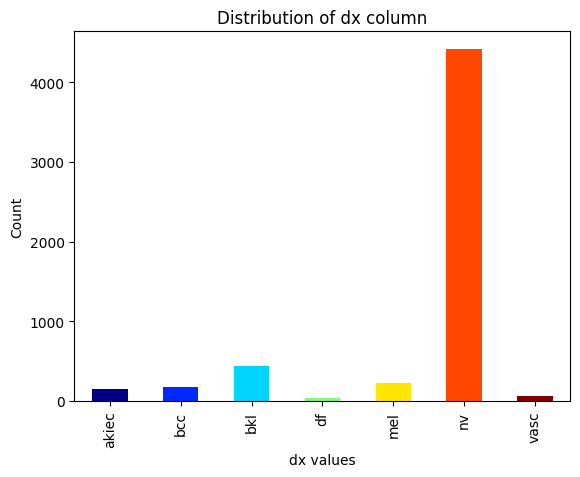

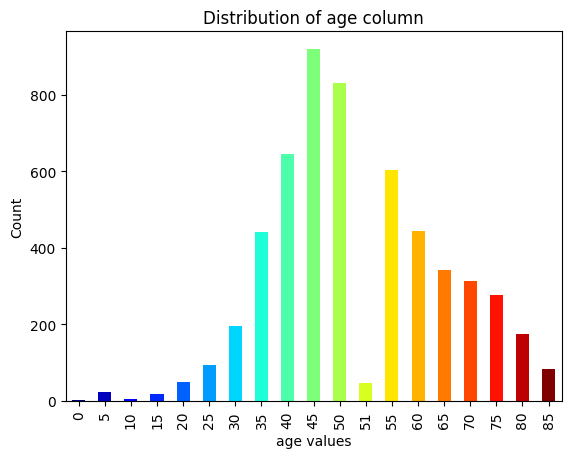

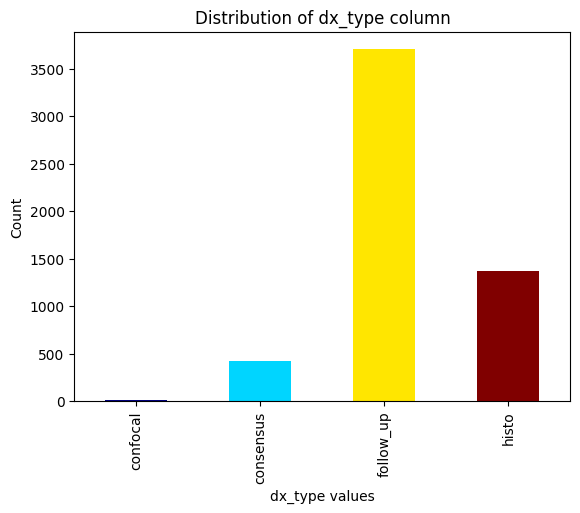

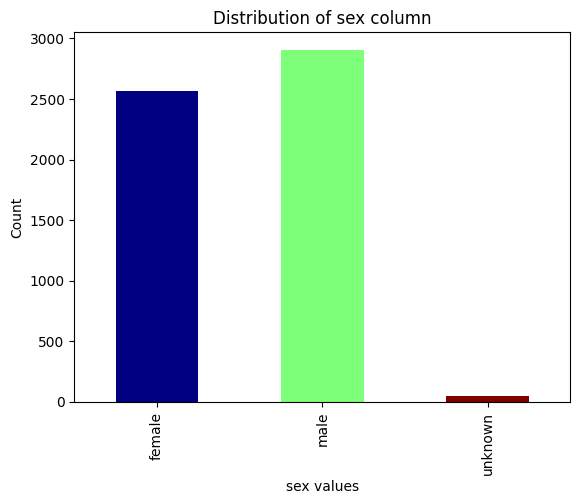

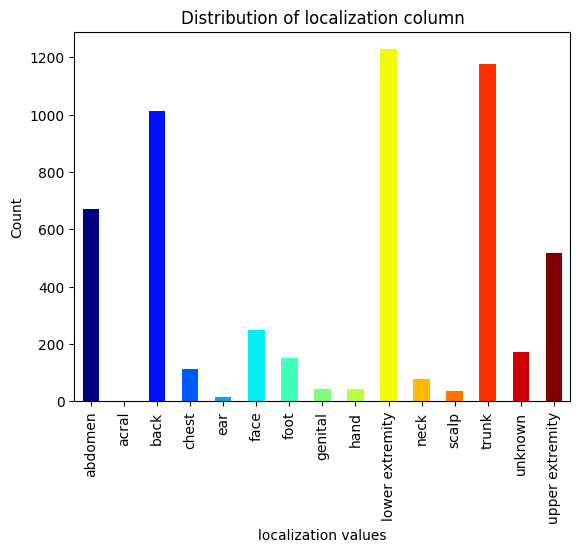

In [15]:
columns_exp = ['dx','age','dx_type', 'sex', 'localization']

for column in columns_exp:
  count = metadata[column].value_counts().sort_index()

  unique_vals = count.index
  colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

  count.plot(kind='bar', color=colors)

  plt.xlabel(f'{column} values')
  plt.ylabel('Count')
  plt.title(f'Distribution of {column} column')
  plt.show()

In [16]:
metadata.loc[metadata['sex']=='unknown'].shape

(45, 9)

In [17]:
metadata.loc[metadata['localization']=='unknown'].shape

(173, 9)

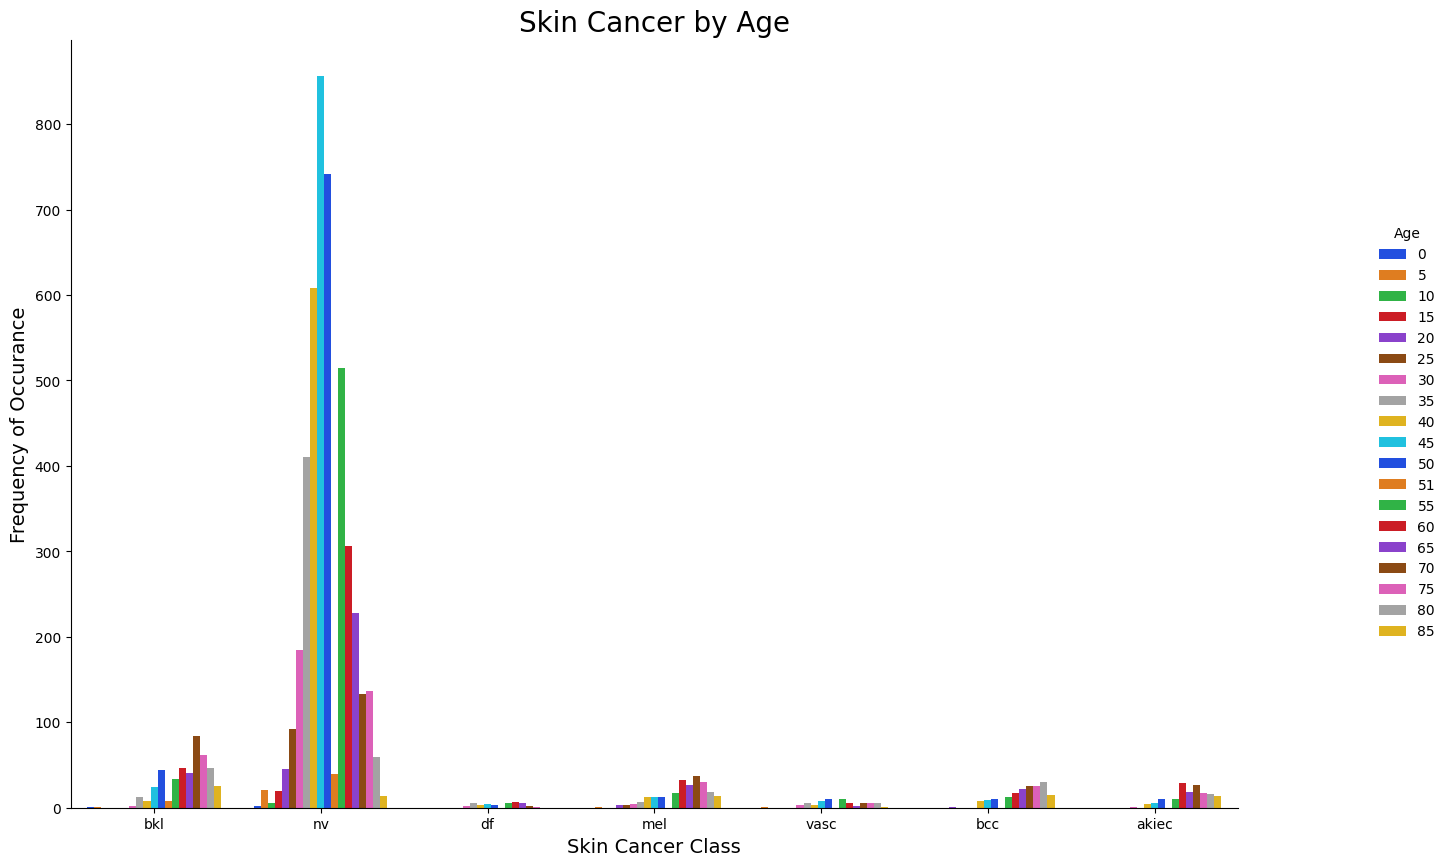

In [18]:
#Skin Cancer by age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Age')

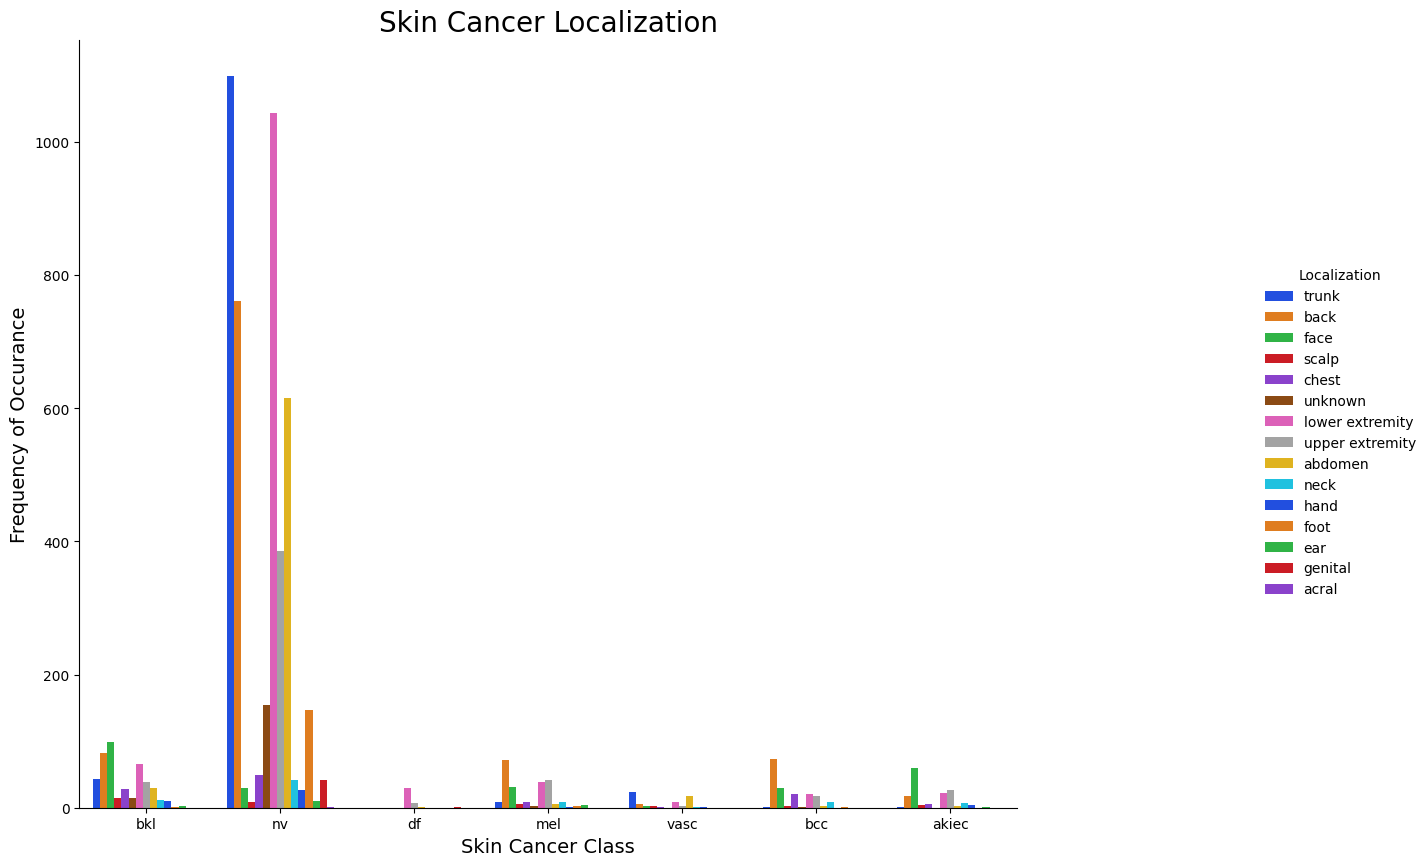

In [19]:
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

In [20]:
metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                           image_path  
10  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
15  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
20  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
33  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
34  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

### Plot images from each class and their color distributions

In [21]:
def pltImg(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {labels[i]}\nMean intensity: {np.mean(image):.1f}")

    plt.tight_layout()
    plt.show()


def pltHist(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array
    colors = ["red", "green", "blue"]

    for i, image in enumerate(images):
        image_array = np.array(image)

        # Plotting all channels with colors
        for channel in range(3):
            hist, bin_edges = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
            axes[i].plot(bin_edges[:-1], hist, color=colors[channel])

        axes[i].set_title(f"Class: {labels[i]}")

    plt.tight_layout()
    plt.show()

In [22]:
def randImg(df, label, seed, sample_size):
    # Filter dataframe for specific label/class
    df_class = df[df['dx'] == label]

    # Randomly sample images from this class
    random.seed(seed)
    sample_df = df_class.sample(n=sample_size)

    images = []
    labels = []
    for index, row in sample_df.iterrows():
        image_path = row['image_path']
        if os.path.exists(image_path):
            image = Image.open(image_path)
            images.append(image)
            labels.append(label)
        else:
            print(f"Image not found: {image_path}")

    return images, labels


--- Showcasing examples for class: bkl ---



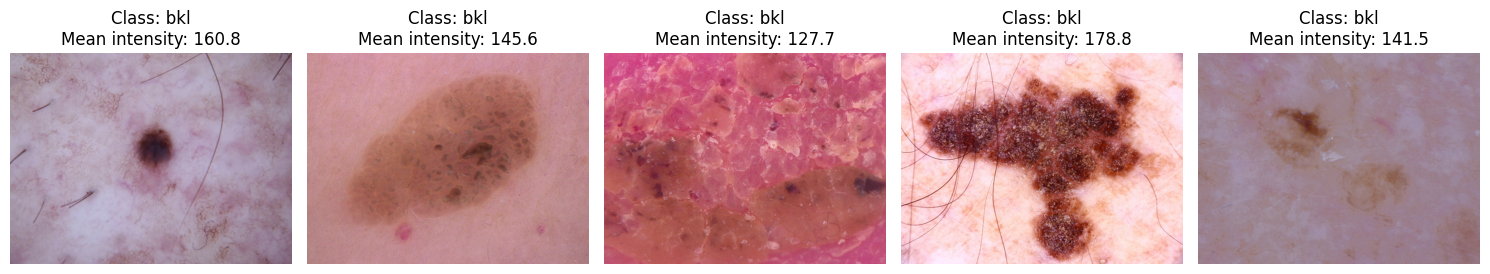

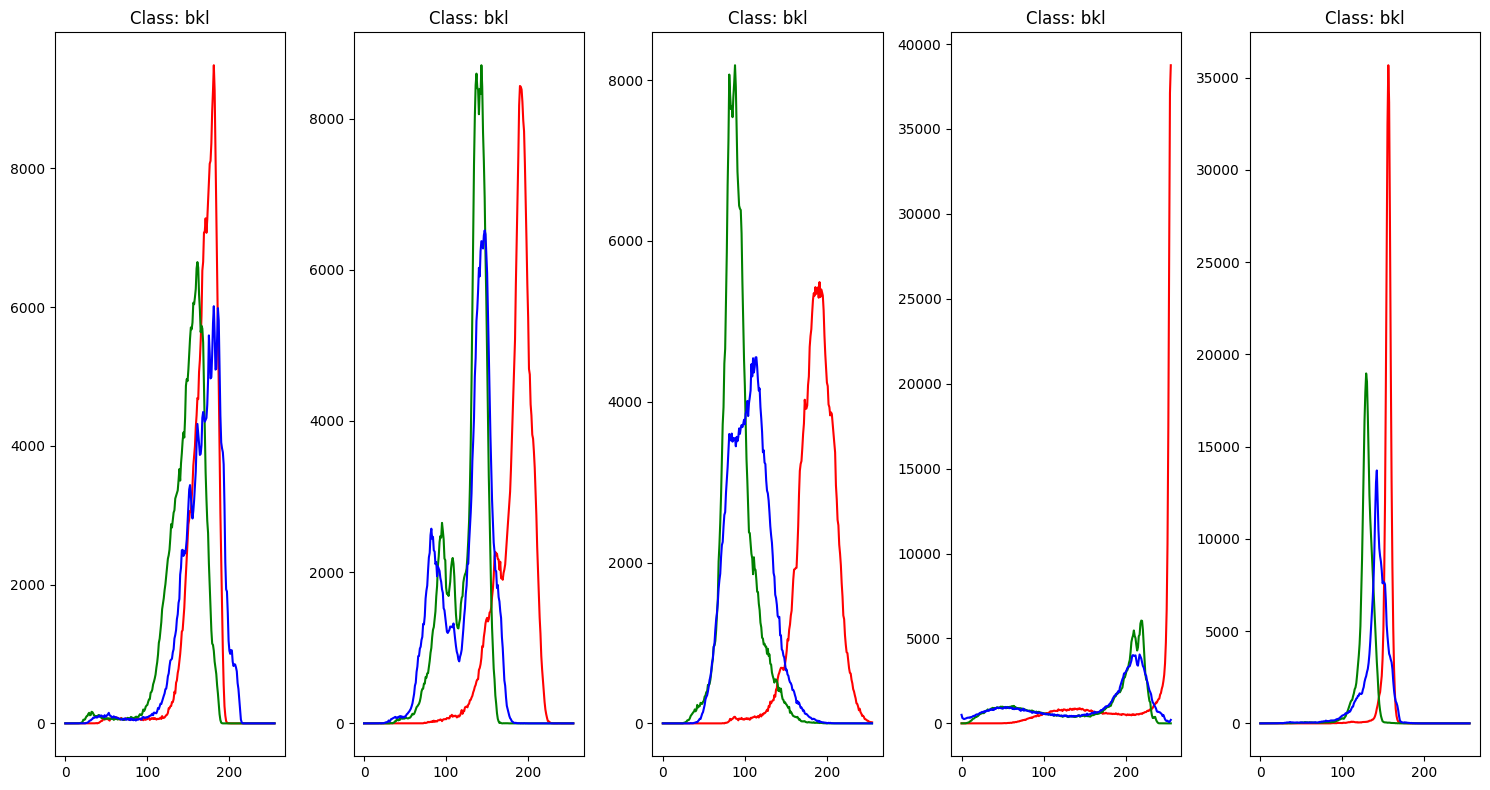


--- Showcasing examples for class: nv ---



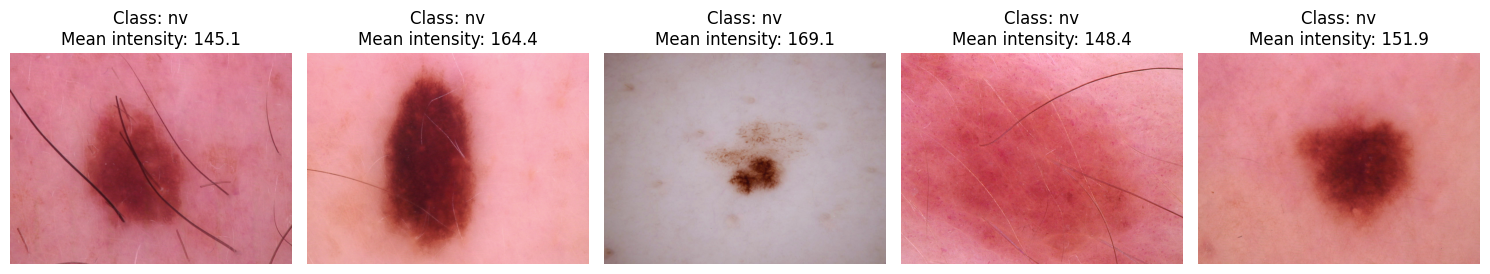

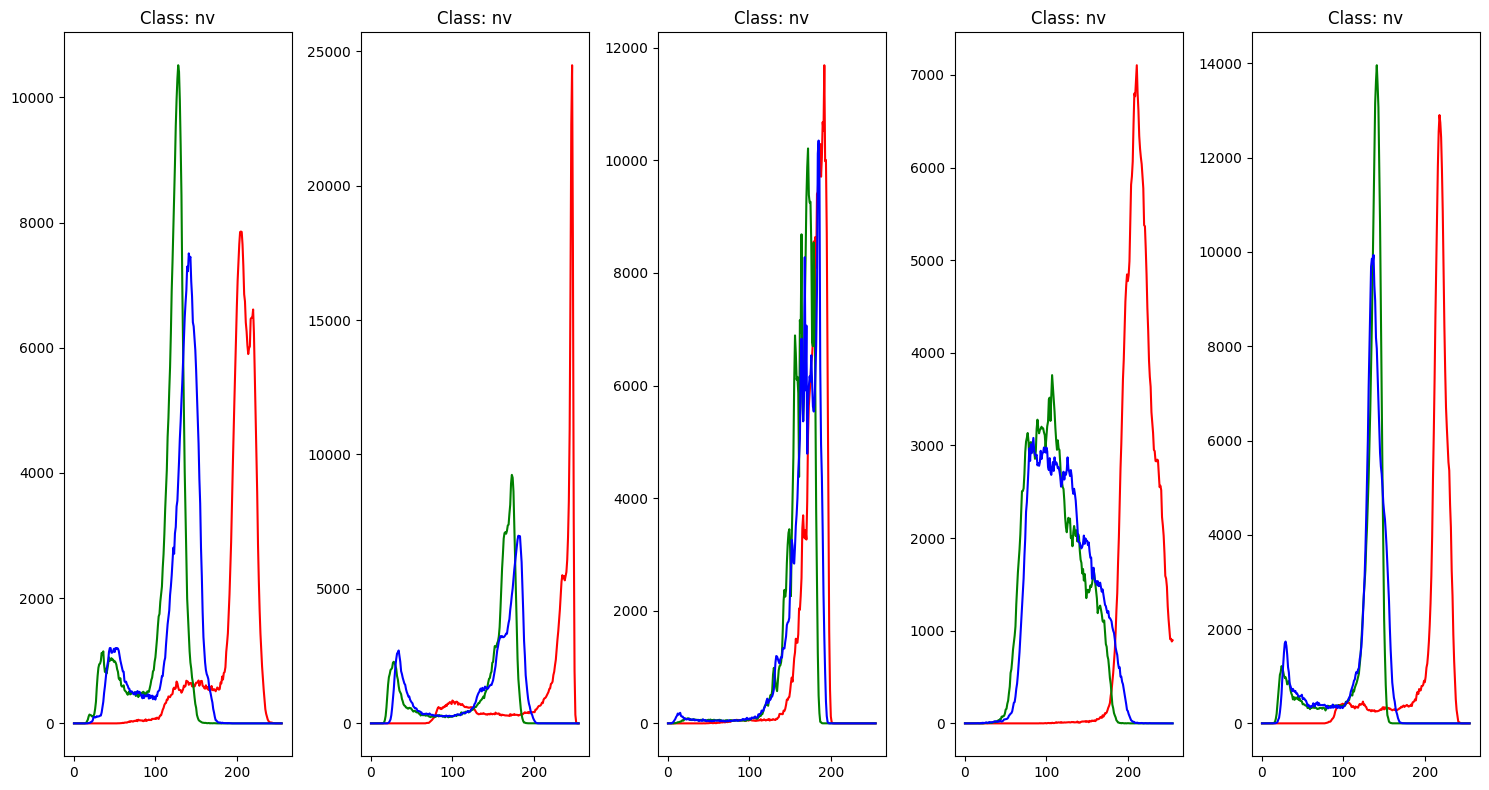


--- Showcasing examples for class: df ---



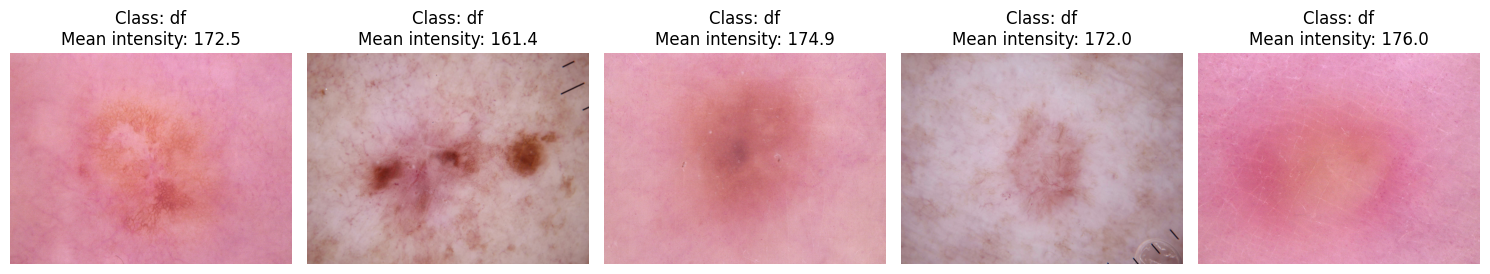

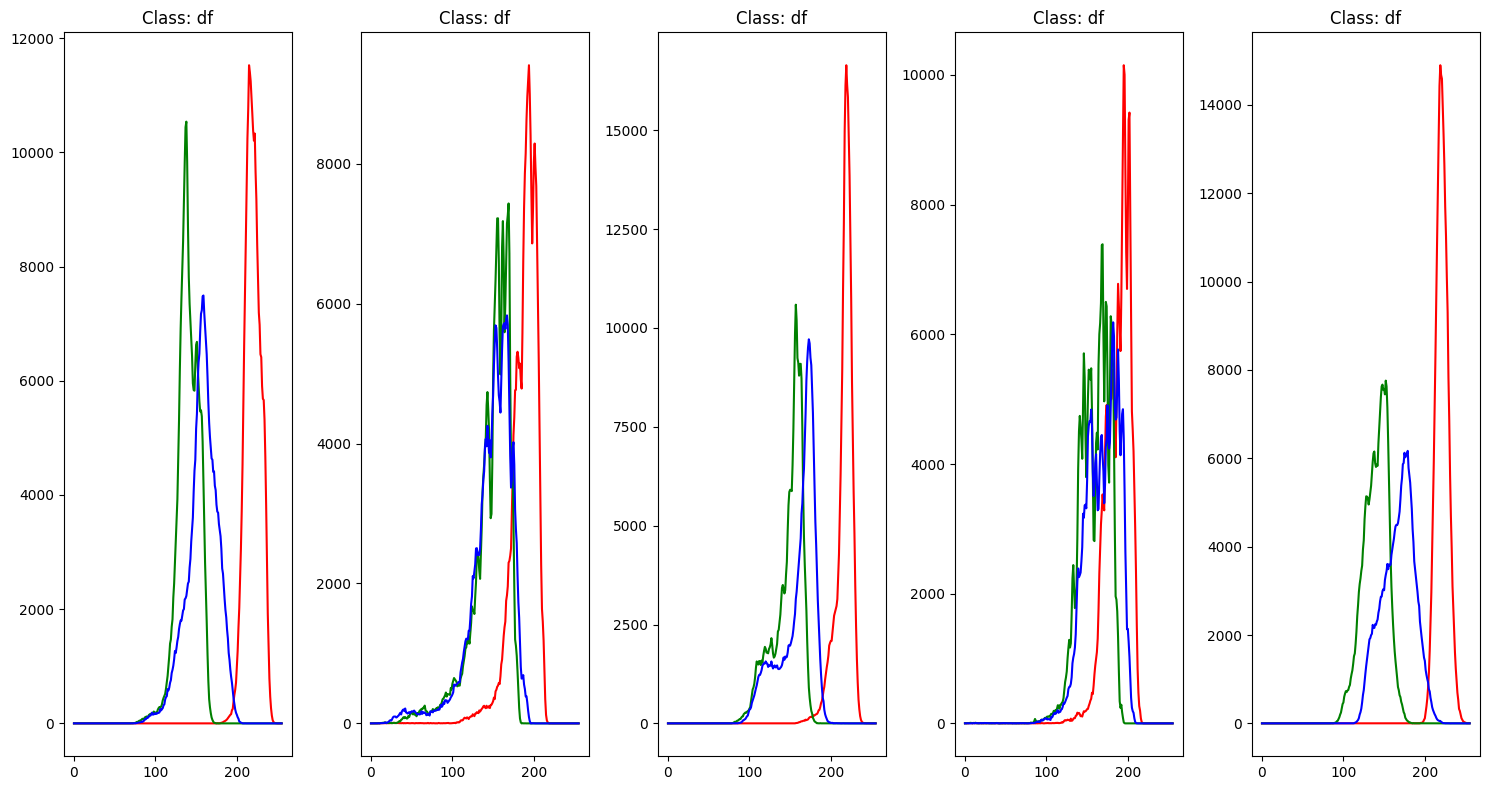


--- Showcasing examples for class: mel ---



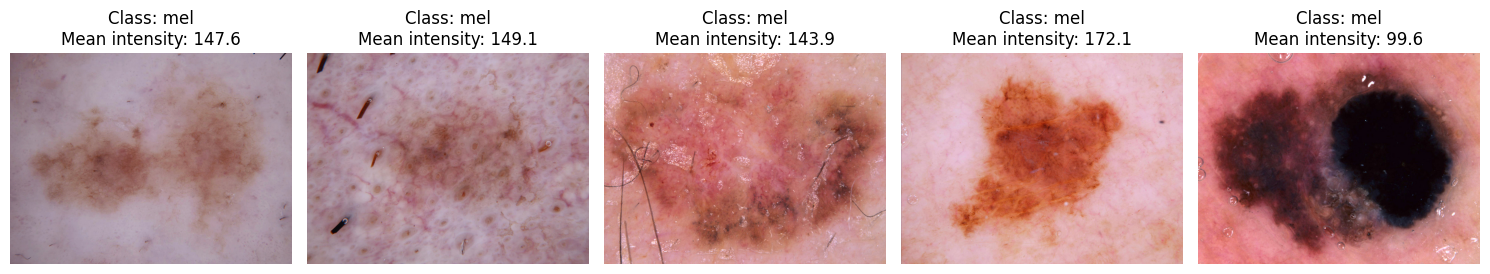

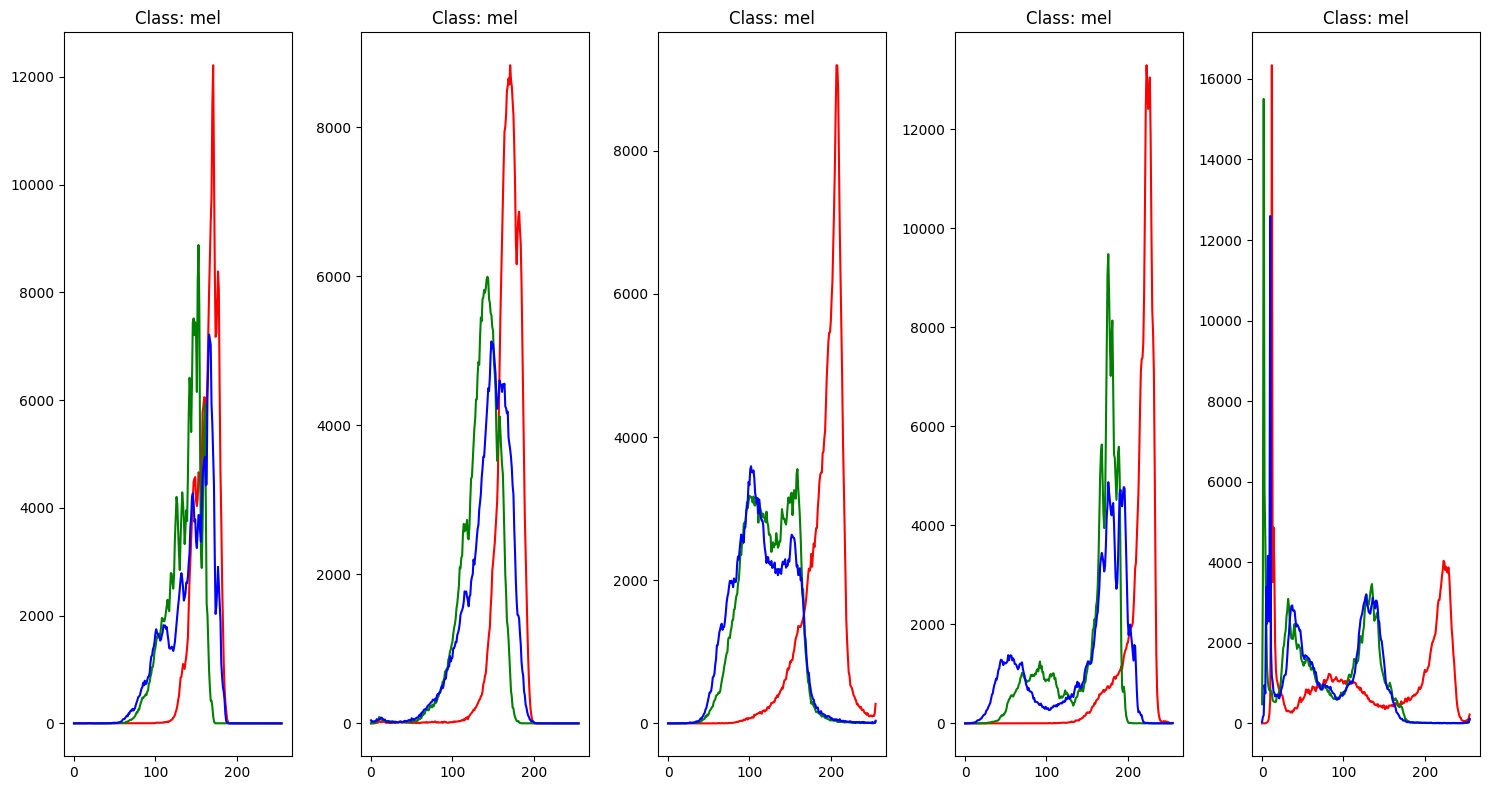


--- Showcasing examples for class: vasc ---



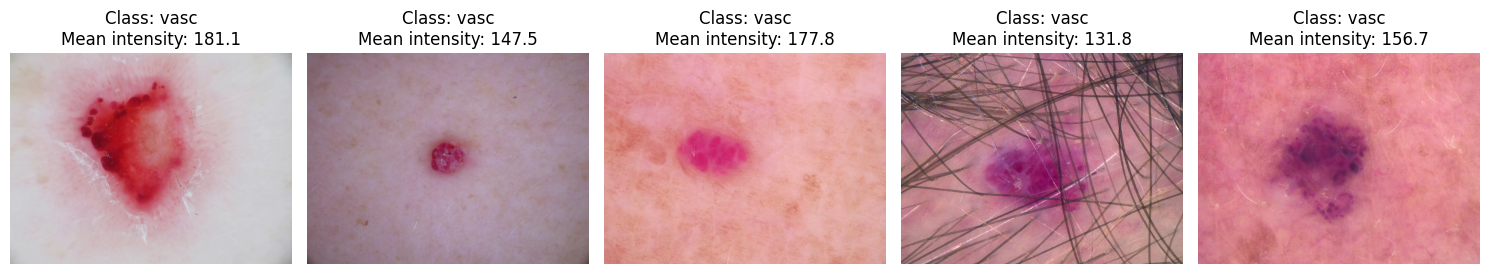

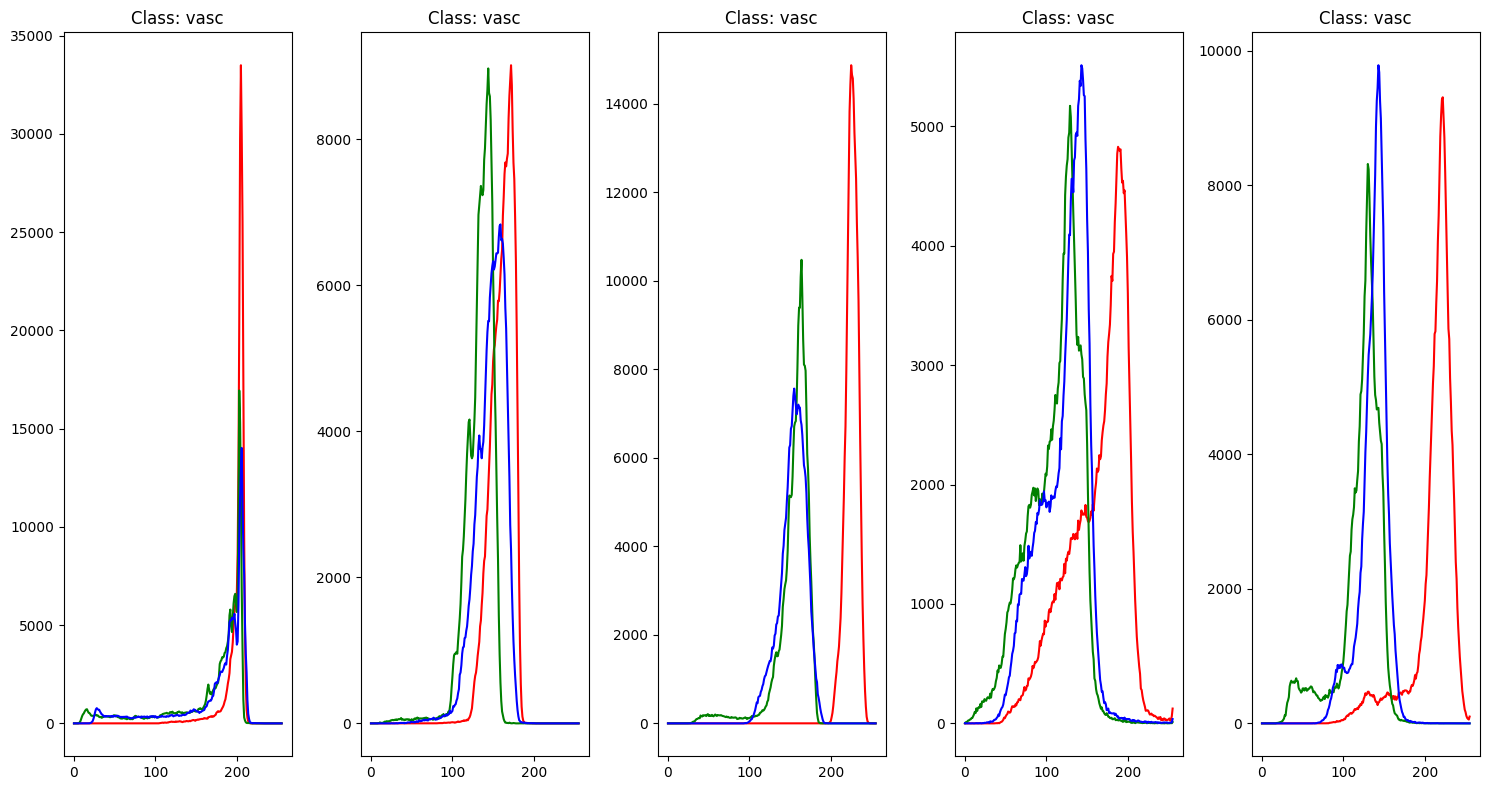


--- Showcasing examples for class: bcc ---



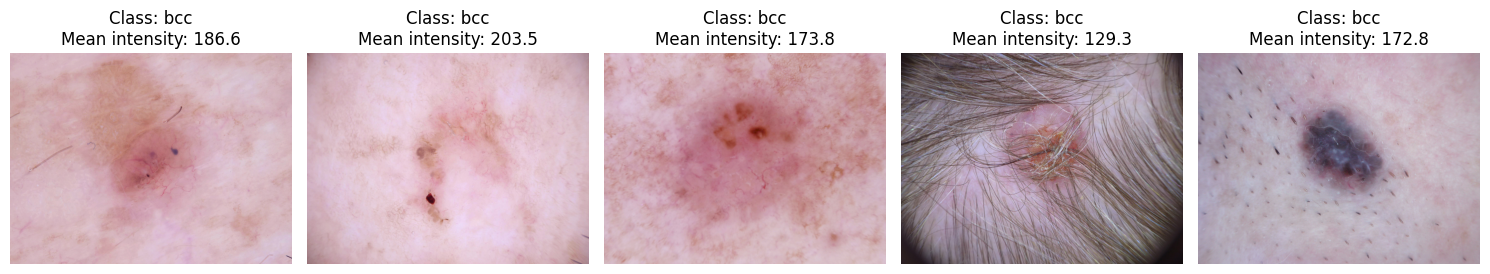

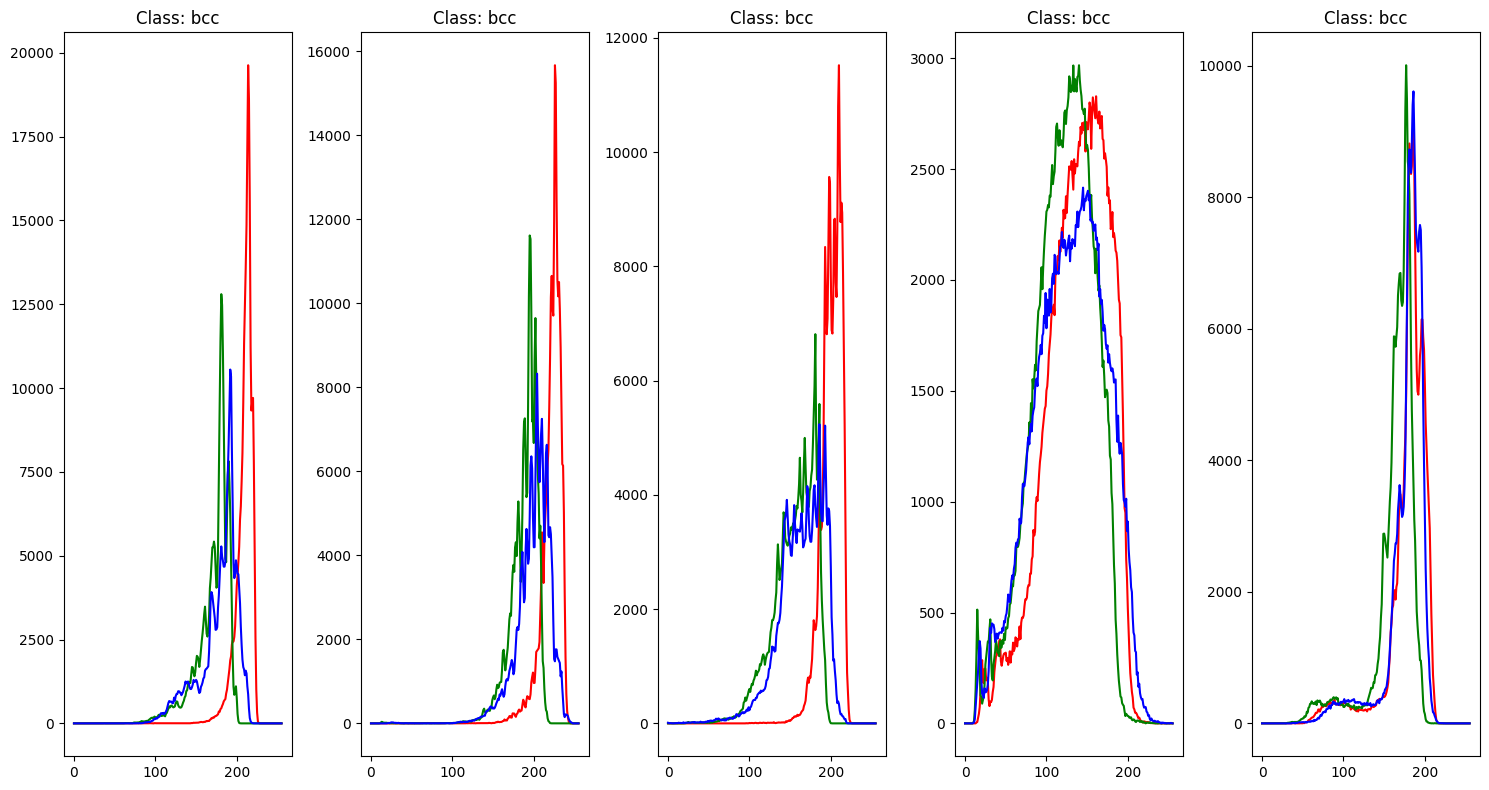


--- Showcasing examples for class: akiec ---



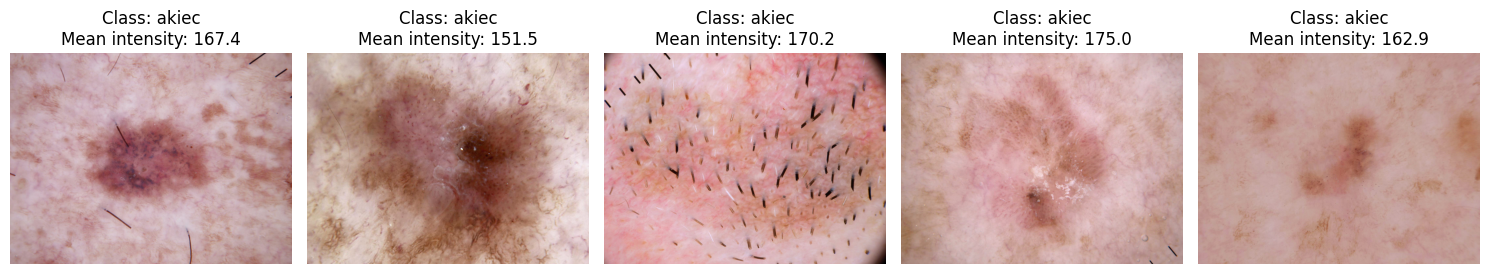

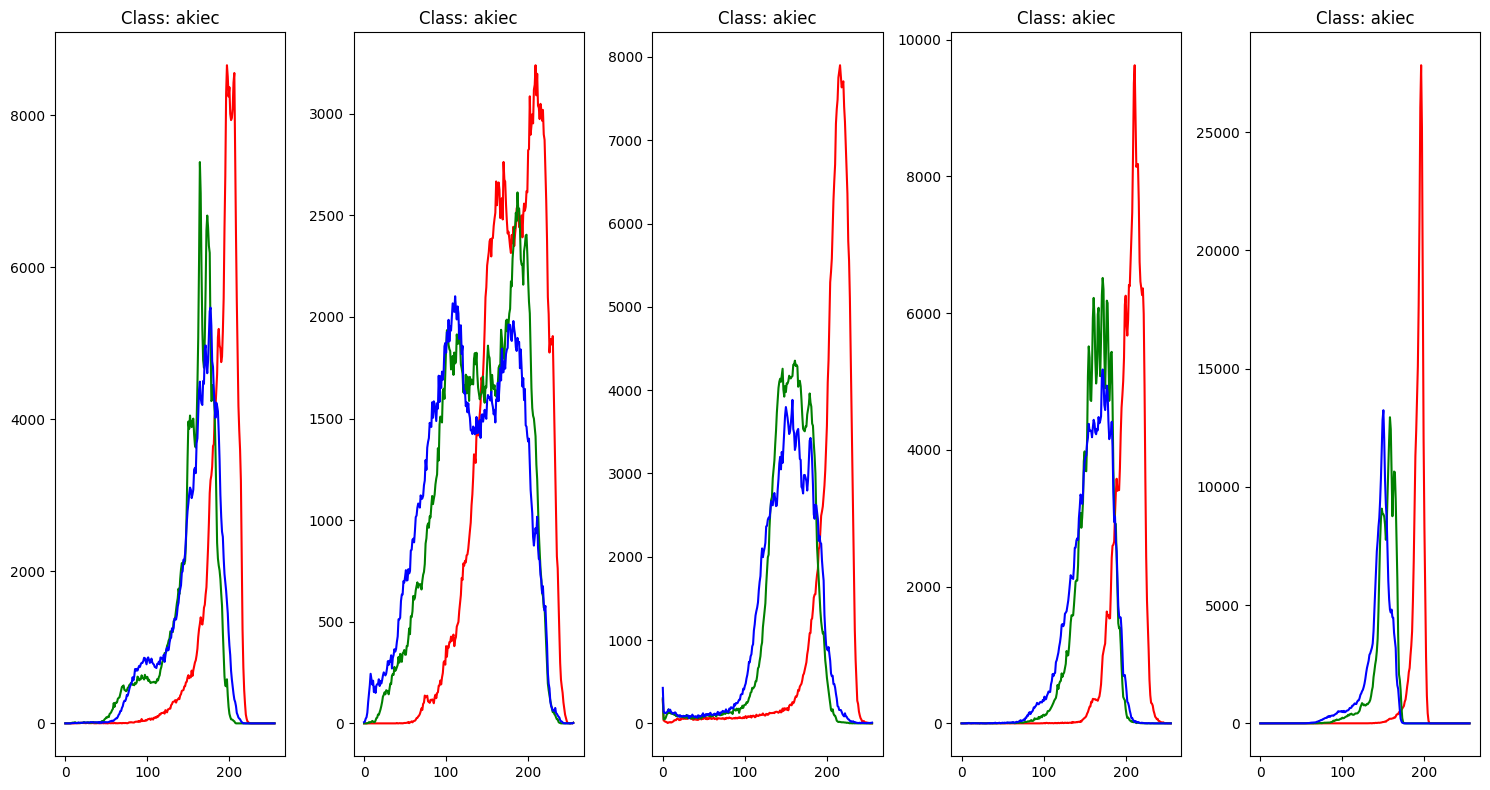

In [23]:
class_labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for class_label in class_labels:
    print(f"\n--- Showcasing examples for class: {class_label} ---\n")
    images, labels = randImg(df=metadata, label=class_label, seed=42, sample_size=5)

    # For displaying images
    pltImg(images, labels, 1, 5)
    # pltImgEq(images, labels, 1, 5)
    # For displaying histograms
    pltHist(images, labels, 1, 5)

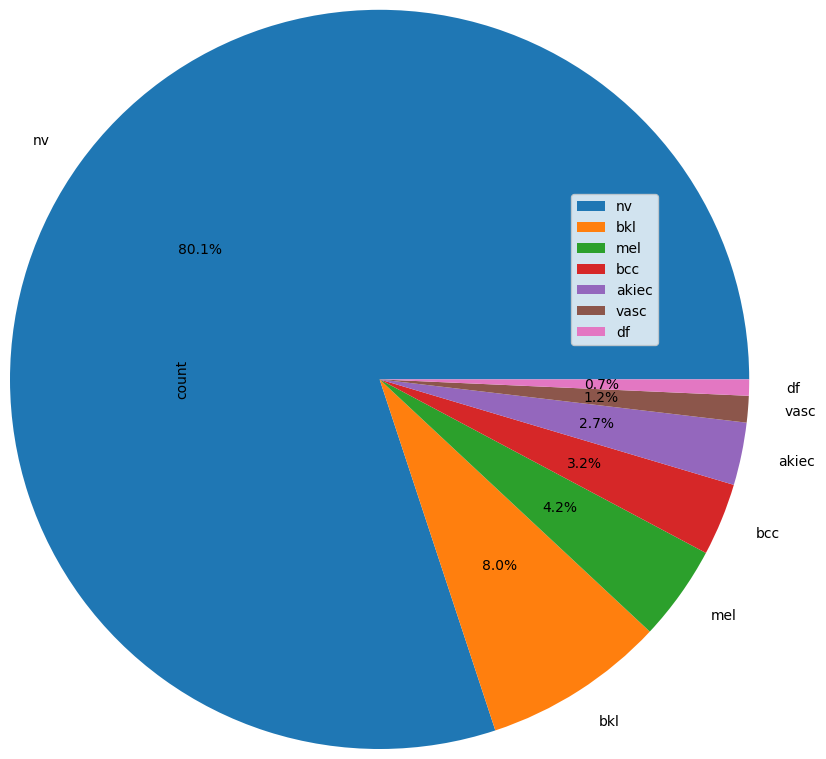

In [24]:
count = metadata['dx'].value_counts()
ax = count.plot(kind="pie", autopct='%1.1f%%', legend=True,radius=2.5)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [25]:
count

dx
nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: count, dtype: int64

LABELS :

Melanocytic nevi (nv) -
Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.

[4415 images]

Melanoma (mel) -
Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.

[230 images]

Benign keratosis-like lesions (bkl) -
"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.

[440 images]

Basal cell carcinoma (bcc) -
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.

[175 images]

Actinic keratoses (akiec) -
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.

[151 images]

Vascular lesions (vasc) -
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.

[64 images]

Dermatofibrom (df) -
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].

[39 images]

[Total images = 5514]

### Data Augmentation maintaining unbalanced dataset

In [26]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [27]:
count = metadata['dx'].value_counts().sort_index()
count

dx
akiec     151
bcc       175
bkl       440
df         39
mel       230
nv       4415
vasc       64
Name: count, dtype: int64

<Axes: ylabel='count'>

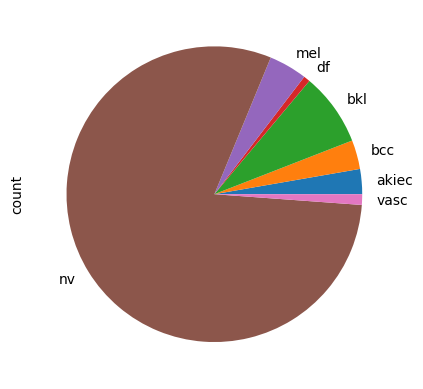

In [28]:
count.plot(kind='pie')

### Data Export

For metadata['dx']:

'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6

<Axes: ylabel='count'>

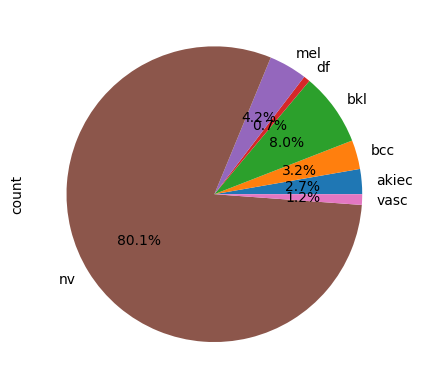

In [29]:
from sklearn.utils import shuffle

# We will perform data augmentation maintaining the class distribution

def data_aug_unbalanced(df, col_name, val_name, augmentation_factor):
    given_class = df[df[col_name] == val_name]
    original_count = len(given_class)
    target_count = int(original_count * augmentation_factor)

    # sample with replacement to generate aaugmented data
    augmented_class = given_class.sample(target_count, replace=True, random_state=42)

    return augmented_class

# get class counts and proportions
class_counts = metadata['dx'].value_counts()
class_proportions = class_counts / len(metadata)

# Define the augmentation factor for the entire dataset
augmentation_factor = 3  # E.g., double the dataset size

# Initialize an empty DataFrame to store the augmented dataset
augmented_metadata = pd.DataFrame()

# Perform augmentation for each class proportionally
for class_label, proportion in class_proportions.items():
    augmented_class = data_aug_unbalanced(
        metadata, col_name='dx', val_name=class_label, augmentation_factor=augmentation_factor
    )
    augmented_metadata = pd.concat([augmented_metadata, augmented_class], axis=0)

# Shuffle the augmented dataset to ensure randomness
augmented_metadata = shuffle(augmented_metadata, random_state=42).reset_index(drop=True)

# Map class labels to categorical values
enum_labels = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
augmented_metadata['dx_cat'] = augmented_metadata['dx'].map(enum_labels)

# Export the augmented dataset to a CSV file
augmented_metadata.to_csv('data_unbalanced.csv', index=False)

# Optional: Visualize the class distribution
class_distribution = augmented_metadata['dx'].value_counts().sort_index()
class_distribution.plot(kind='pie', autopct='%1.1f%%')

The new file data_unbalanced.csv it was created and saved in Output (working) directory. This directory is writable and is the default working directory in a Kaggle notebook.

__________

In [30]:
!pip install torchsummary
!pip install Dataloaders

In [31]:
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms

#from Dataloaders.HAM10000Dataset import HAM10000Dataset
#from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc
import optuna
import logging

## HAM10000 Dataset

In [32]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx_cat', img_col='image_path', transform=None):
        """
        Custom Dataset for loading HAM10000 images and labels.

        Args:
            data (pd.DataFrame): DataFrame containing image paths and labels.
            label_column (str): Name of the column containing labels.
            img_col (str): Name of the column containing image paths.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data.reset_index(drop=True)
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        # Get image path
        image_path = self.data.at[idx, self.img_col]

        # Open image
        image = Image.open(image_path).convert('RGB')

        # Get label
        label = self.data.at[idx, self.label_column]
        label = torch.tensor(label, dtype=torch.long)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

## Model Functions

In [33]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(val_loader)
    valid_accuracy = 100 * correct / total
    return avg_valid_loss, valid_accuracy

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def train_and_validate_model(model, train_loader, val_loader, test_loader, criterion, patience, optimizer, device, epochs, model_filename, verbose=False):
    min_valid_loss = np.inf

    total_loss_train = []
    total_loss_val = []
    total_acc_train = []
    total_acc_val = []
    stopping_ct = 0

    for epoch in tqdm(range(epochs)):
        if stopping_ct < patience:            
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            valid_loss, valid_acc = validate_epoch(model, val_loader, criterion, device)

            total_loss_train.append(train_loss)
            total_loss_val.append(valid_loss)
            total_acc_train.append(train_acc)
            total_acc_val.append(valid_acc)
            if verbose:
                print(f'Epoch {epoch+1}')
                print(f'Training Loss: {train_loss} \nTraining Accuracy: {train_acc}%')
                print(f'Validation Loss: {valid_loss} \nValidation Accuracy: {valid_acc}%')
                print('=======================================================================')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \nSaving The Model')
            print('=======================================================================')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_filename)
            stopping_ct = 0
        else:
            stopping_ct += 1

    best_model_state = torch.load(model_filename)
    model.load_state_dict(best_model_state)
    return model,total_loss_train, total_loss_val, total_acc_train, total_acc_val


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialise_model(model_name, num_classes, feature_extract, use_pretrained=True):
    '''
    grad = if the pretrained weights be updated
    use_pretrained = use pre trained weights or start from scratch
    '''
    model = None
    
    if model_name == 'resnet_pret':
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet_pret':
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, choose between 'resnet_pret', 'densenet_pret'.")
        exit()
    return model_ft


def conf_report(model_fitted,loader, model_type):
    """
    Generate and display a confusion matrix and a classification report for the predictions made by a model.

    Parameters:
    - model_fitted: The trained model that will be used to make predictions. The model should be compatible
                    with the data provided by the loader and should have a `to` method for device management
                    and an `argmax` method for getting predictions.
    - loader: A data loader that provides batches of data. Each batch should be a tuple containing data
              and its corresponding labels. The loader should be iterable.
    - model_type: A string indicating the type of the model. This is used for labeling purposes
                  when saving the confusion matrix figure.

    The function does the following:
    - Iterates over the provided data loader to collect model predictions and true labels.
    - Computes a confusion matrix both in raw and normalized form.
    - Displays heatmaps for both raw and normalized confusion matrices.
    - Prints a classification report showing main classification metrics.

    Outputs:
    - A figure with two subplots: the left one showing the normalized confusion matrix and the right
      one showing the raw confusion matrix. The figure is saved as 'Confusion_Matrix_{model_type}.png'.
    - A printed classification report in the console.
    """
    y_pred = []
    y_true = []
    for data, target in loader:
        data, target = data.to('cpu'), target.to('cpu')
        model_cpu = model_fitted.to('cpu')
        output = model_cpu(data)
        y_pred.extend(output.argmax(dim=1).tolist())
        y_true.extend(target.tolist())
    
    classes = [ 'bkl','nv','df','mel','vasc','bcc','akiec']

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_temp = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis], index=classes, columns=classes)

    plt.figure(figsize=(24, 10))  

    plt.subplot(1, 2, 1)  
    sns.heatmap(df_temp, annot=True, fmt=".3f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.subplot(1, 2, 2)  
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Raw Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.savefig(f'Confusion_Matrix_{model_type}.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=classes)
    print('-------------------------------------------------------')
    print("Classification Report:\n")
    print(report)
    print('-------------------------------------------------------')

_____

In [34]:
data = pd.read_csv('/kaggle/working/data_unbalanced.csv')
data = data.sample(frac=1)
data.head()

lesion_id      image_id   dx    dx_type  age     sex localization  \
3156  HAM_0005288  ISIC_0026354   nv  follow_up   60    male        trunk   
2883  HAM_0003427  ISIC_0032959  bcc      histo   50    male         face   
3344  HAM_0004591  ISIC_0027743   nv  follow_up   45  female        trunk   
1389  HAM_0005204  ISIC_0024749   nv  follow_up   70  female        trunk   
3154  HAM_0004985  ISIC_0024518   nv      histo   35  female         back   

      dup_les                                         image_path  dx_cat  
3156    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
2883    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       5  
3344    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
1389    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
3154    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1

## Preprocessing

### Normalize function

In [35]:
img_h, img_w = 224, 224

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

### Data Augmentation and normalization

Resize the data as 224x224 because most pretrained models are implemented to work with these sizes

In [36]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [37]:
data.head()

lesion_id      image_id   dx    dx_type  age     sex localization  \
3156  HAM_0005288  ISIC_0026354   nv  follow_up   60    male        trunk   
2883  HAM_0003427  ISIC_0032959  bcc      histo   50    male         face   
3344  HAM_0004591  ISIC_0027743   nv  follow_up   45  female        trunk   
1389  HAM_0005204  ISIC_0024749   nv  follow_up   70  female        trunk   
3154  HAM_0004985  ISIC_0024518   nv      histo   35  female         back   

      dup_les                                         image_path  dx_cat  
3156    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
2883    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       5  
3344    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
1389    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
3154    False  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1

### Data Loading

In [38]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [39]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 6616 Val: 6617 Test: 3309


### Batch check

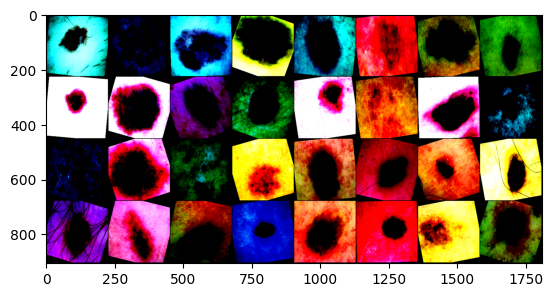

Labels:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 6, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [40]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Resnet

In [42]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [44]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [45]:
start_time = time.time()

In [46]:
epochs = 30
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.629133175464644 
Training Accuracy: 80.48669891172914%
Validation Loss: 0.553288383004458 
Validation Accuracy: 82.16714523197824%
Validation Loss Decreased(inf--->0.553288) 
Saving The Model


  7%|▋         | 2/30 [03:56<55:20, 118.58s/it]

Epoch 2
Training Loss: 0.5743432246544511 
Training Accuracy: 81.0459492140266%
Validation Loss: 0.5543969827141739 
Validation Accuracy: 81.59286685809279%
Epoch 3
Training Loss: 0.539004927708043 
Training Accuracy: 81.74123337363966%
Validation Loss: 0.5246902332429725 
Validation Accuracy: 82.72631101707722%
Validation Loss Decreased(0.553288--->0.524690) 
Saving The Model


 10%|█         | 3/30 [05:58<54:04, 120.18s/it]

Epoch 4
Training Loss: 0.5194304936749924 
Training Accuracy: 82.43651753325273%
Validation Loss: 0.49299993459585206 
Validation Accuracy: 82.98322502644703%
Validation Loss Decreased(0.524690--->0.493000) 
Saving The Model


 13%|█▎        | 4/30 [08:00<52:22, 120.88s/it]

Epoch 5
Training Loss: 0.4977404041494724 
Training Accuracy: 82.34582829504232%
Validation Loss: 0.4838869449309105 
Validation Accuracy: 84.08644400785855%
Validation Loss Decreased(0.493000--->0.483887) 
Saving The Model


 17%|█▋        | 5/30 [10:02<50:31, 121.27s/it]

Epoch 6
Training Loss: 0.482410676813356 
Training Accuracy: 83.58524788391777%
Validation Loss: 0.4581445110376906 
Validation Accuracy: 84.31313283965544%
Validation Loss Decreased(0.483887--->0.458145) 
Saving The Model


 23%|██▎       | 7/30 [14:05<46:34, 121.50s/it]

Epoch 7
Training Loss: 0.49409174746361334 
Training Accuracy: 83.01088270858524%
Validation Loss: 0.4860995849729448 
Validation Accuracy: 82.81698654979598%


 27%|██▋       | 8/30 [16:06<44:32, 121.47s/it]

Epoch 8
Training Loss: 0.471777797177218 
Training Accuracy: 83.61547762998791%
Validation Loss: 0.46405830464645287 
Validation Accuracy: 83.17968868067099%


 30%|███       | 9/30 [18:08<42:30, 121.45s/it]

Epoch 9
Training Loss: 0.45491562402190794 
Training Accuracy: 83.67593712212818%
Validation Loss: 0.5259407071963601 
Validation Accuracy: 82.71119842829077%


 33%|███▎      | 10/30 [20:09<40:26, 121.31s/it]

Epoch 10
Training Loss: 0.4510786583746113 
Training Accuracy: 83.79685610640871%
Validation Loss: 0.47466516564937605 
Validation Accuracy: 83.49705304518665%
Epoch 11
Training Loss: 0.43541423674078955 
Training Accuracy: 84.3409915356711%
Validation Loss: 0.4314447562187766 
Validation Accuracy: 84.41892096116065%
Validation Loss Decreased(0.458145--->0.431445) 
Saving The Model


 37%|███▋      | 11/30 [22:11<38:28, 121.49s/it]

Epoch 12
Training Loss: 0.4228671479628282 
Training Accuracy: 84.77932285368803%
Validation Loss: 0.4073690564016213 
Validation Accuracy: 85.31056369956174%
Validation Loss Decreased(0.431445--->0.407369) 
Saving The Model


 43%|████▎     | 13/30 [26:14<34:25, 121.51s/it]

Epoch 13
Training Loss: 0.4220186440984984 
Training Accuracy: 84.96070133010883%
Validation Loss: 0.42715388428473816 
Validation Accuracy: 84.5095964938794%


 47%|████▋     | 14/30 [28:15<32:22, 121.41s/it]

Epoch 14
Training Loss: 0.4088934900392081 
Training Accuracy: 85.39903264812575%
Validation Loss: 0.4098276023703497 
Validation Accuracy: 85.1745504004836%


 50%|█████     | 15/30 [30:17<30:22, 121.52s/it]

Epoch 15
Training Loss: 0.40491204845588563 
Training Accuracy: 85.47460701330108%
Validation Loss: 0.4323326948364288 
Validation Accuracy: 84.81184826960859%
Epoch 16
Training Loss: 0.401631283911242 
Training Accuracy: 85.27811366384522%
Validation Loss: 0.38538209509086496 
Validation Accuracy: 86.83693516699411%
Validation Loss Decreased(0.407369--->0.385382) 
Saving The Model


 53%|█████▎    | 16/30 [32:18<28:20, 121.48s/it]

Epoch 17
Training Loss: 0.3812845943018722 
Training Accuracy: 86.32103990326482%
Validation Loss: 0.3785226999957492 
Validation Accuracy: 86.82182257820764%
Validation Loss Decreased(0.385382--->0.378523) 
Saving The Model


 60%|██████    | 18/30 [36:21<24:16, 121.33s/it]

Epoch 18
Training Loss: 0.3801805131893227 
Training Accuracy: 86.36638452237001%
Validation Loss: 0.4026522507738088 
Validation Accuracy: 85.6581532416503%
Epoch 19
Training Loss: 0.37963789064383163 
Training Accuracy: 86.35126964933495%
Validation Loss: 0.35967935161026204 
Validation Accuracy: 87.09384917636392%
Validation Loss Decreased(0.378523--->0.359679) 
Saving The Model


 63%|██████▎   | 19/30 [38:22<22:13, 121.23s/it]

Epoch 20
Training Loss: 0.37519845726409395 
Training Accuracy: 86.50241837968561%
Validation Loss: 0.3511535000901867 
Validation Accuracy: 87.53211425117122%
Validation Loss Decreased(0.359679--->0.351154) 
Saving The Model


 70%|███████   | 21/30 [42:24<18:10, 121.17s/it]

Epoch 21
Training Loss: 0.3647701851123773 
Training Accuracy: 86.7291414752116%
Validation Loss: 0.3637137427062228 
Validation Accuracy: 87.33565059694726%


 73%|███████▎  | 22/30 [44:25<16:08, 121.04s/it]

Epoch 22
Training Loss: 0.3573336743610205 
Training Accuracy: 86.83494558645707%
Validation Loss: 0.3548159570869616 
Validation Accuracy: 87.36587577452018%


 77%|███████▋  | 23/30 [46:26<14:06, 120.94s/it]

Epoch 23
Training Loss: 0.355167088445258 
Training Accuracy: 86.74425634824668%
Validation Loss: 0.36128574104052813 
Validation Accuracy: 87.5018890735983%
Epoch 24
Training Loss: 0.3390271181717587 
Training Accuracy: 87.8174123337364%
Validation Loss: 0.33874934028096243 
Validation Accuracy: 88.10639262505667%
Validation Loss Decreased(0.351154--->0.338749) 
Saving The Model


 83%|████████▎ | 25/30 [50:27<10:04, 120.91s/it]

Epoch 25
Training Loss: 0.33262136961886846 
Training Accuracy: 87.89298669891173%
Validation Loss: 0.3413500146589417 
Validation Accuracy: 88.28774369049418%


 87%|████████▋ | 26/30 [52:28<08:03, 120.81s/it]

Epoch 26
Training Loss: 0.33347280946186775 
Training Accuracy: 87.89298669891173%
Validation Loss: 0.38727397288101306 
Validation Accuracy: 86.29288197068158%


 90%|█████████ | 27/30 [54:29<06:02, 120.79s/it]

Epoch 27
Training Loss: 0.3209972323642837 
Training Accuracy: 88.46735187424426%
Validation Loss: 0.4513213496277298 
Validation Accuracy: 83.16457609188454%
Epoch 28
Training Loss: 0.33418690611198903 
Training Accuracy: 87.65114873035067%
Validation Loss: 0.33305382183280546 
Validation Accuracy: 87.41121354087956%
Validation Loss Decreased(0.338749--->0.333054) 
Saving The Model


 97%|█████████▋| 29/30 [58:30<02:00, 120.78s/it]

Epoch 29
Training Loss: 0.3113180958274482 
Training Accuracy: 88.46735187424426%
Validation Loss: 0.3523538423081239 
Validation Accuracy: 87.78902826054103%
Epoch 30
Training Loss: 0.30800602703854657 
Training Accuracy: 88.78476420798066%
Validation Loss: 0.3128420431976733 
Validation Accuracy: 88.66555841015565%
Validation Loss Decreased(0.333054--->0.312842) 
Saving The Model


100%|██████████| 30/30 [1:00:31<00:00, 121.07s/it]
/tmp/ipykernel_23/944843552.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filen

In [47]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 60.54 minutes


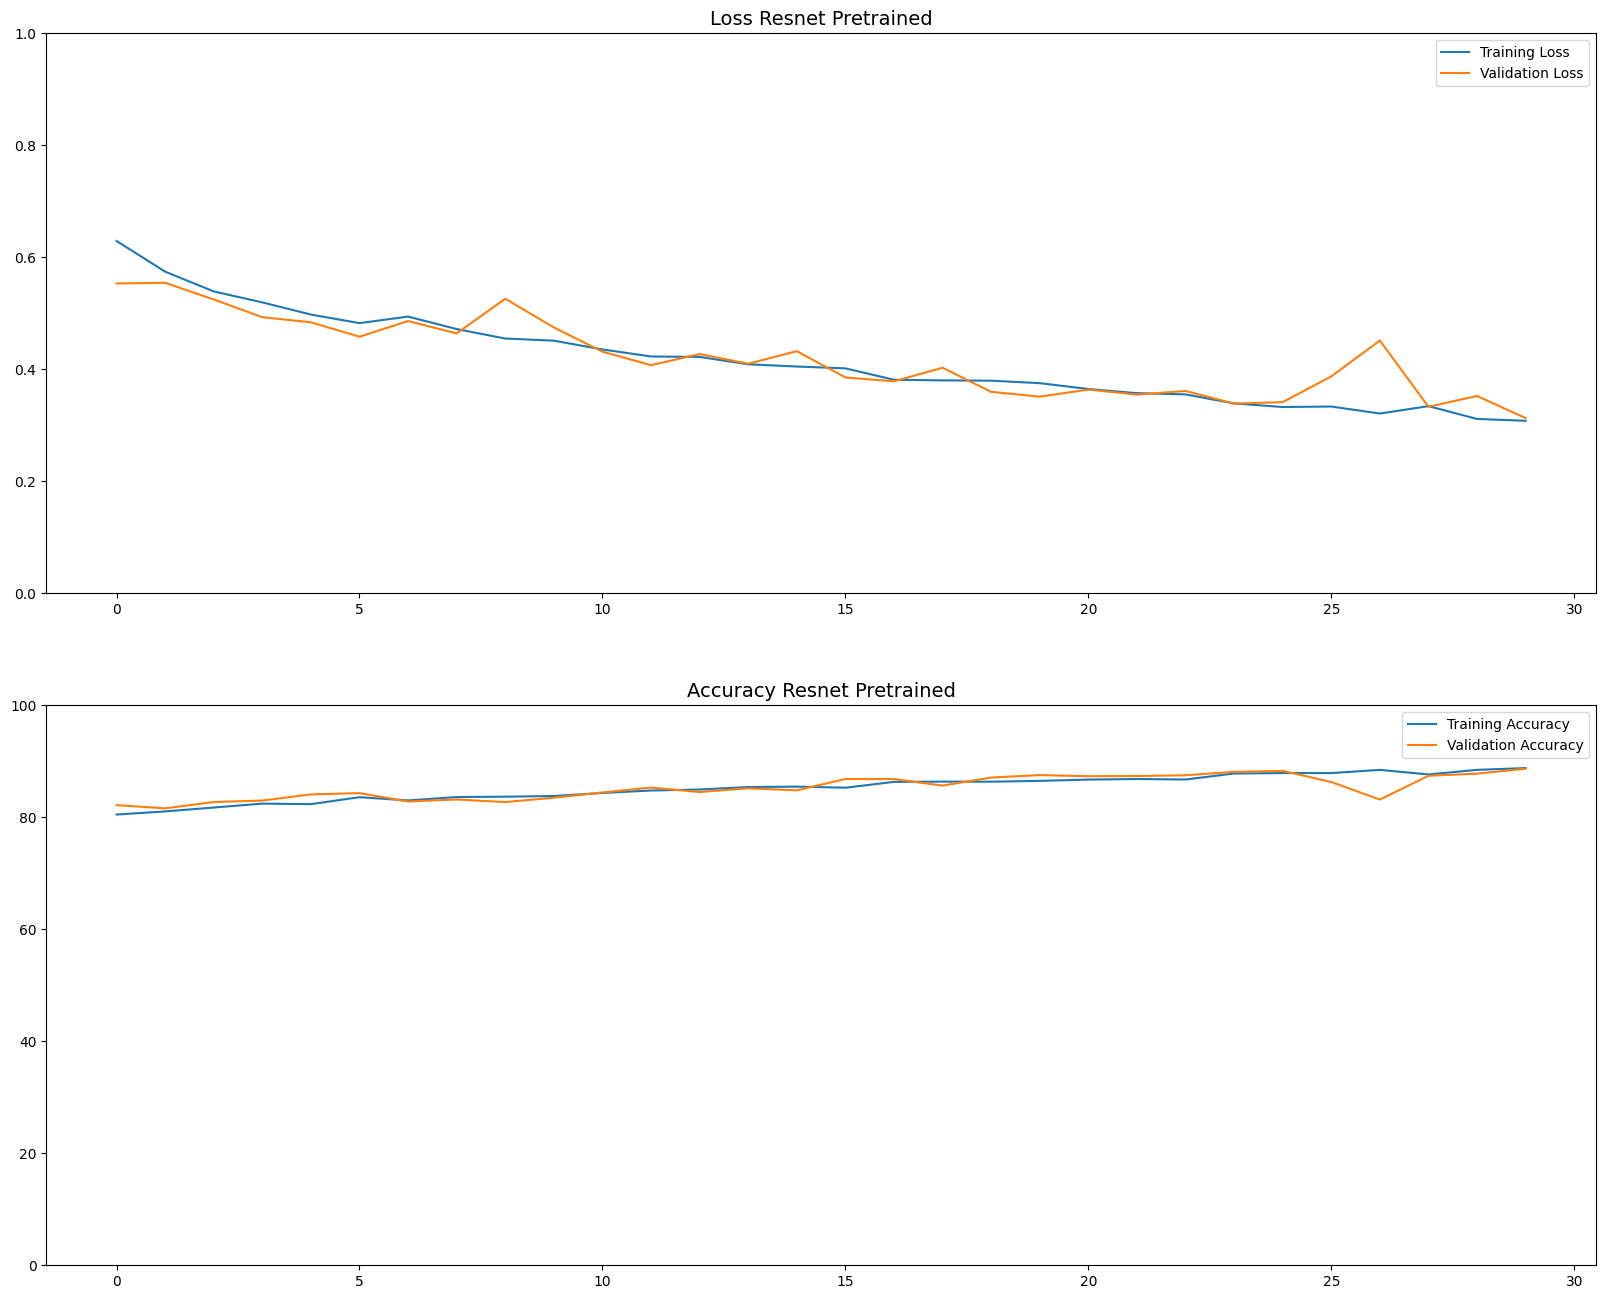

In [48]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [49]:
best_model_state = torch.load('resnet_pret.pth', map_location='cpu', weights_only=False)
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best model's accuracy: 89.42278634028408
-------------------------------------------------------


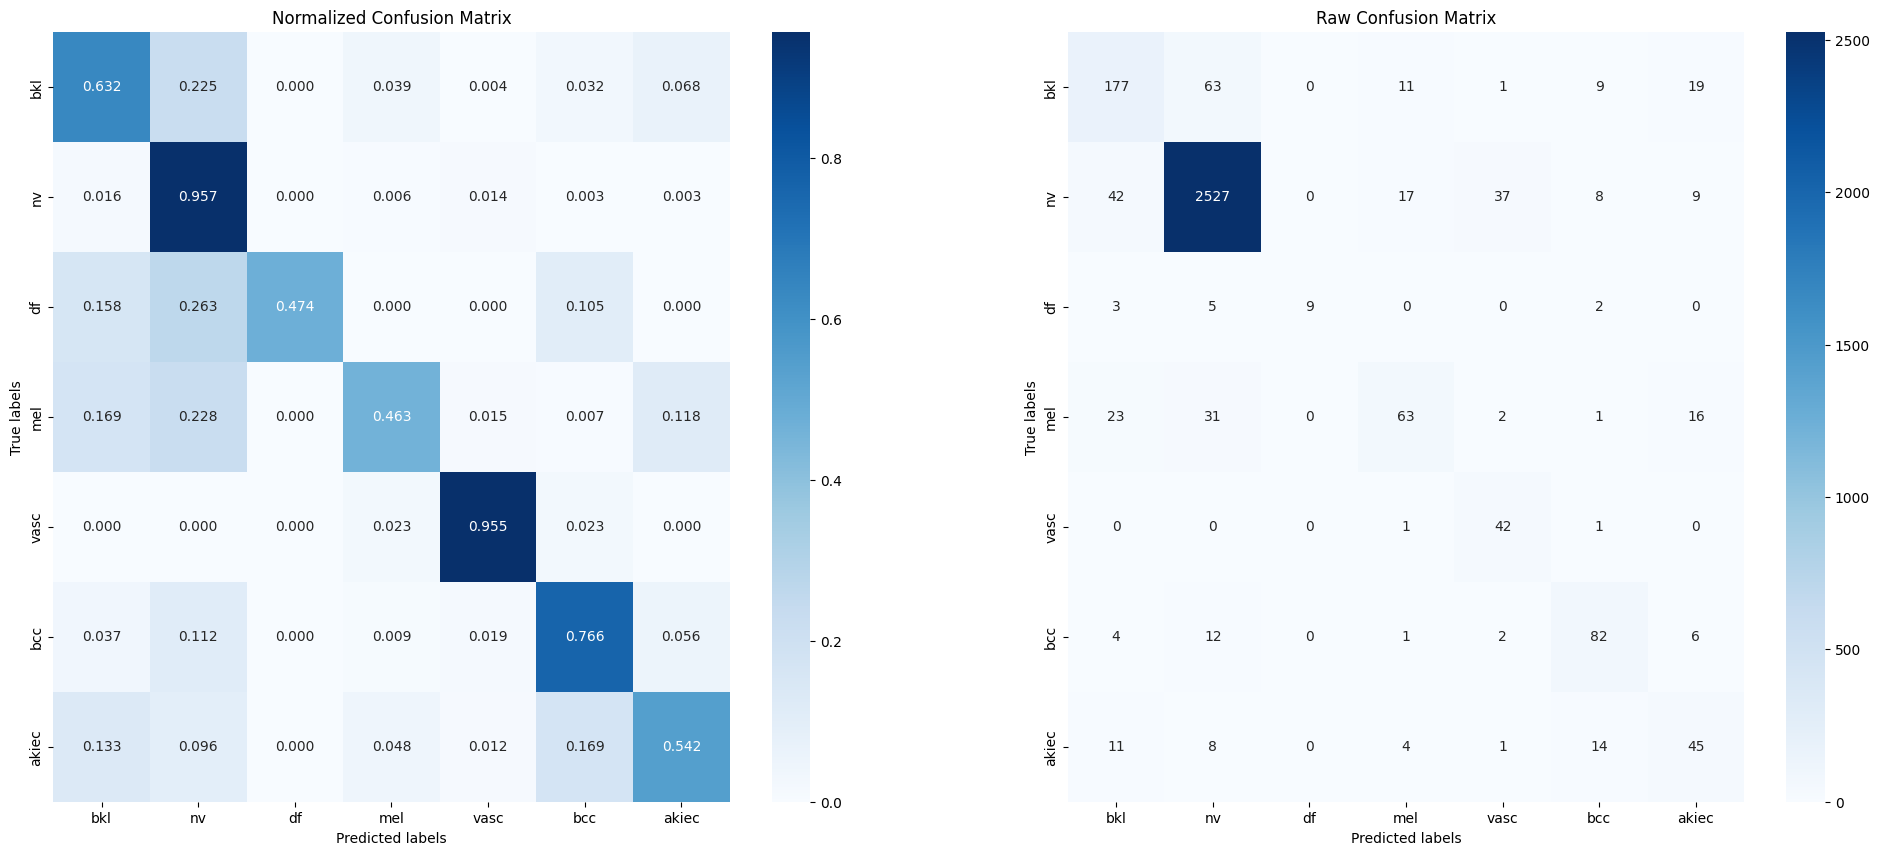

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.68      0.63      0.66       280
          nv       0.96      0.96      0.96      2640
          df       1.00      0.47      0.64        19
         mel       0.65      0.46      0.54       136
        vasc       0.49      0.95      0.65        44
         bcc       0.70      0.77      0.73       107
       akiec       0.47      0.54      0.51        83

    accuracy                           0.89      3309
   macro avg       0.71      0.68      0.67      3309
weighted avg       0.89      0.89      0.89      3309

-------------------------------------------------------


In [50]:
conf_report(model_res, test_loader, 'resnet_conf_mat')